# ML Project - Soft Margin SVM

## Alireza Habibzadeh
## Student number `99109393`

In [1]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from tqdm import tqdm
from scipy.spatial.distance import cdist

import sys
print(sys.version)

3.12.1 (main, Dec  7 2023, 20:45:44) [Clang 15.0.0 (clang-1500.0.40.1)]


In [2]:
# Load datasets
X_test,  y_test  = load_svmlight_file('satimage.scale.t')
X_train, y_train = load_svmlight_file('satimage.scale.tr')
X_val,   y_val   = load_svmlight_file('satimage.scale.val')

# 1. Linear Kernel

داده‌های دو کلاس ۴ و ۶ را جدا می‌کنیم:

In [3]:
def two_class_filter(X, y, class1, class2):
    indices = np.where((y == class1) | (y == class2))[0]
    X_filtered = X[indices].toarray()
    y_filtered = y[indices]
    y_filtered = np.where(y_filtered == class1, -1, 1)
    return X_filtered, y_filtered

X_train_binary, y_train_binary = two_class_filter(X_train, y_train, 4, 6)
X_val_binary, y_val_binary = two_class_filter(X_val, y_val, 4, 6)
X_test_binary, y_test_binary = two_class_filter(X_test, y_test, 4, 6)

سعی کردم برای محسبات از حلقه استفاده نکنم و از عملگرهای نامپای استفاده کنم تا عملکرد خوب باشد. نکته این است که اینجا در نامپای بردارهای ما سطری هستند و لذا همه‌ی روابط به شکل ترانهاده‌شان برقرار هستند.

In [4]:
def accuracy(y_pred, y):
    return np.mean(y_pred == y)

def soft_margin_svm(X, y, C=1.0, threshold=1e-5):
    m, _ = X.shape
    
    # minimizing  (1/2)*x'*P*x + q'*x
    # subject to  G*x <= h
    # and         A*x = b.
    # (From the documentation of cvxopt.solvers.qp)
    
    dots = np.dot(X, X.T)
    
    # P[i, j] = y[i] * y[j] * X[i]^T * X[j]
    yyT = np.outer(y, y)
    P = matrix(dots * yyT, (m, m), 'd')
    # q = (-1, -1, ..., -1)^T
    q = matrix(-np.ones(m))
    # G = [-I, I]
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    # h = [0, ..., 0, C, ..., C]^T
    h = matrix(np.hstack((np.zeros(m), C * np.ones(m))))
    # A = y^T
    A = matrix(y.reshape(1, -1), (1, m), 'd')
    # b = 0
    b = matrix(0.0)

    sol = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(sol['x']).flatten()

    # Non-zero alphas (support vectors)
    sv_indices = np.where(alphas > threshold)[0]
    alpha_sv = alphas[sv_indices]
    X_sv = X[sv_indices]
    y_sv = y[sv_indices]
    
    w = np.sum(alpha_sv * y_sv * X_sv.T, axis=1)
    # Can use any support vector here but the mean is more stable against numerical errors
    b = np.mean(y_sv - np.dot(X_sv, w))
    
    # E_in
    y_pred = np.sign(np.dot(X, w) + b)
    print(f'Train Accuracy: {accuracy(y_pred, y) * 100:.2f}%')
    return w, b

# Training time
w, b = soft_margin_svm(X_train_binary, y_train_binary, C=1.0)

y_test_pred = np.sign(np.dot(X_test_binary, w) + b)
print(f'Test Accuracy: {accuracy(y_test_pred, y_test_binary) * 100:.2f}%')

     pcost       dcost       gap    pres   dres
 0: -4.1814e+02 -2.1475e+03  1e+04  3e+00  5e-14
 1: -2.8867e+02 -1.4286e+03  2e+03  3e-01  5e-14
 2: -2.7710e+02 -4.7698e+02  2e+02  2e-02  5e-14
 3: -3.0754e+02 -3.9958e+02  1e+02  8e-03  4e-14
 4: -3.2114e+02 -3.7229e+02  5e+01  4e-03  4e-14
 5: -3.2791e+02 -3.6008e+02  3e+01  2e-03  4e-14
 6: -3.3417e+02 -3.4949e+02  2e+01  9e-04  5e-14
 7: -3.3732e+02 -3.4436e+02  7e+00  3e-04  5e-14
 8: -3.3870e+02 -3.4213e+02  3e+00  1e-04  4e-14
 9: -3.3959e+02 -3.4086e+02  1e+00  3e-05  5e-14
10: -3.4009e+02 -3.4022e+02  1e-01  4e-14  5e-14
11: -3.4015e+02 -3.4016e+02  8e-03  7e-14  5e-14
12: -3.4016e+02 -3.4016e+02  2e-04  5e-14  6e-14
Optimal solution found.
Train Accuracy: 83.59%
Test Accuracy: 80.18%


In [5]:
print('Confusion Matrix:')
print(confusion_matrix(y_test_binary, y_test_pred))

# noinspection LanguageDetectionInspection
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_test_pred) * 100:.2f}%')

Confusion Matrix:
[[146  65]
 [ 70 400]]
Balanced Accuracy: 77.15%


# 2. RBF Kernel

In [6]:
def rbf_kernel(x1, x2, sigma=1.0):
    # e^(-||x1 - x2||**2 / (2 * sigma**2))
    return np.exp(-cdist(x1, x2, 'sqeuclidean') / (2 * sigma**2))

def soft_margin_svm_rbf(X, y, C=1.0, threshold=1e-5, sigma=1.0):
    m, _ = X.shape
    
    # minimizing  (1/2)*x'*P*x + q'*x
    # subject to  G*x <= h
    # and         A*x = b.
    # (From the documentation of cvxopt.solvers.qp)
    
    dots = rbf_kernel(X, X, sigma)
    
    # P[i, j] = y[i] * y[j] * X[i]^T * X[j]
    yyT = np.outer(y, y)
    P = matrix(dots * yyT, (m, m), 'd')
    # q = (-1, -1, ..., -1)^T
    q = matrix(-np.ones(m))
    # G = [-I, I]
    G = matrix(np.vstack((-np.eye(m), np.eye(m))))
    # h = [0, ..., 0, C, ..., C]^T
    h = matrix(np.hstack((np.zeros(m), C * np.ones(m))))
    # A = y^T
    A = matrix(y.reshape(1, -1), (1, m), 'd')
    # b = 0
    b = matrix(0.0)

    sol = solvers.qp(P, q, G, h, A, b)

    alphas = np.array(sol['x']).flatten()

    # Support vectors have non-zero alphas
    sv_indices = np.where(alphas > threshold)[0]
    alpha_sv = alphas[sv_indices]
    X_sv = X[sv_indices]
    y_sv = y[sv_indices]
    
    # Like before can use any support vector but mean is more stable against numerical errors
    b = np.mean(y_sv - np.dot(alpha_sv * y_sv, rbf_kernel(X_sv, X_sv, sigma).T))
    
    # Predict on the train set
    y_pred = np.sign(np.dot(rbf_kernel(X, X_sv, sigma), alpha_sv * y_sv) + b)
    print(f'Train Accuracy: {accuracy(y_pred, y) * 100:.2f}%')
    return alpha_sv, X_sv, y_sv, b

# Test with sigma = 1.0
sigma = 1.0
alpha_sv, X_sv, y_sv, b = soft_margin_svm_rbf(X_train_binary, y_train_binary, C=1.0, sigma=sigma)

y_test_pred = np.sign(np.dot(rbf_kernel(X_test_binary, X_sv, sigma), alpha_sv * y_sv) + b)

# Evaluate the accuracy on the validation set
print(f'Test Accuracy: {accuracy(y_test_pred, y_test_binary) * 100:.2f}%')

     pcost       dcost       gap    pres   dres
 0: -2.7748e+02 -1.9680e+03  9e+03  3e+00  1e-14
 1: -2.0156e+02 -1.2147e+03  1e+03  1e-01  1e-14
 2: -2.1622e+02 -4.0266e+02  2e+02  2e-02  1e-14
 3: -2.4562e+02 -2.9889e+02  6e+01  4e-03  1e-14
 4: -2.5620e+02 -2.7584e+02  2e+01  1e-03  1e-14
 5: -2.6093e+02 -2.6672e+02  6e+00  2e-04  1e-14
 6: -2.6263e+02 -2.6388e+02  1e+00  3e-05  1e-14
 7: -2.6309e+02 -2.6319e+02  1e-01  5e-07  1e-14
 8: -2.6313e+02 -2.6314e+02  3e-03  1e-08  1e-14
 9: -2.6313e+02 -2.6313e+02  6e-05  2e-10  1e-14
Optimal solution found.
Train Accuracy: 90.44%
Test Accuracy: 87.81%


## Finding the best hyperparameter ($\sigma$)

  0%|          | 0/21 [00:00<?, ?it/s]

     pcost       dcost       gap    pres   dres
 0: -3.4747e+02 -1.4163e+03  1e+03  5e-13  5e-16
 1: -3.5961e+02 -4.0391e+02  4e+01  1e-12  3e-16
 2: -3.7217e+02 -3.7307e+02  9e-01  5e-12  5e-17
 3: -3.7246e+02 -3.7247e+02  9e-03  4e-12  1e-16


  5%|▍         | 1/21 [00:00<00:08,  2.22it/s]

 4: -3.7246e+02 -3.7246e+02  9e-05  3e-12  4e-17
Optimal solution found.
Train Accuracy: 100.00%
Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.4747e+02 -1.4163e+03  1e+03  5e-13  5e-16
 1: -3.5961e+02 -4.0391e+02  4e+01  1e-12  3e-16
 2: -3.7217e+02 -3.7307e+02  9e-01  5e-12  5e-17
 3: -3.7246e+02 -3.7247e+02  9e-03  4e-12  1e-16
 4: -3.7246e+02 -3.7246e+02  9e-05  3e-12  4e-17
Optimal solution found.
Train Accuracy: 100.00%


 10%|▉         | 2/21 [00:01<00:09,  1.95it/s]

Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.4747e+02 -1.4163e+03  1e+03  5e-13  5e-16
 1: -3.5961e+02 -4.0391e+02  4e+01  1e-12  3e-16
 2: -3.7217e+02 -3.7307e+02  9e-01  5e-12  5e-17
 3: -3.7246e+02 -3.7247e+02  9e-03  4e-12  1e-16
 4: -3.7246e+02 -3.7246e+02  9e-05  3e-12  4e-17
Optimal solution found.


 14%|█▍        | 3/21 [00:01<00:09,  1.86it/s]

Train Accuracy: 100.00%
Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.4747e+02 -1.4163e+03  1e+03  1e-12  2e-16
 1: -3.5961e+02 -4.0391e+02  4e+01  2e-12  1e-16
 2: -3.7217e+02 -3.7307e+02  9e-01  3e-12  7e-17
 3: -3.7246e+02 -3.7247e+02  9e-03  2e-12  4e-17


 19%|█▉        | 4/21 [00:02<00:10,  1.68it/s]

 4: -3.7246e+02 -3.7246e+02  9e-05  9e-13  4e-17
Optimal solution found.
Train Accuracy: 100.00%
Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.4747e+02 -1.4163e+03  1e+03  3e-13  5e-16
 1: -3.5961e+02 -4.0391e+02  4e+01  5e-13  3e-16
 2: -3.7217e+02 -3.7307e+02  9e-01  1e-12  1e-16


 24%|██▍       | 5/21 [00:02<00:10,  1.57it/s]

 3: -3.7246e+02 -3.7247e+02  9e-03  1e-12  1e-16
 4: -3.7246e+02 -3.7246e+02  9e-05  1e-12  9e-17
Optimal solution found.
Train Accuracy: 100.00%
Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.4696e+02 -1.4159e+03  1e+03  2e-14  8e-16
 1: -3.5907e+02 -4.0393e+02  4e+01  1e-13  4e-16
 2: -3.7163e+02 -3.7258e+02  9e-01  3e-13  2e-16
 3: -3.7194e+02 -3.7195e+02  9e-03  4e-14  1e-16


 29%|██▊       | 6/21 [00:03<00:09,  1.57it/s]

 4: -3.7194e+02 -3.7194e+02  9e-05  4e-13  1e-16
Optimal solution found.
Train Accuracy: 100.00%
Validation Accuracy: 82.01%
     pcost       dcost       gap    pres   dres
 0: -3.0634e+02 -1.4221e+03  1e+03  4e-14  1e-15
 1: -3.1635e+02 -3.9708e+02  8e+01  1e-13  5e-16
 2: -3.2831e+02 -3.3546e+02  7e+00  2e-13  3e-16
 3: -3.2992e+02 -3.3027e+02  4e-01  4e-13  2e-16
 4: -3.3003e+02 -3.3004e+02  1e-02  3e-13  2e-16
 5: -3.3003e+02 -3.3003e+02  6e-04  5e-14  2e-16


 33%|███▎      | 7/21 [00:04<00:10,  1.39it/s]

 6: -3.3003e+02 -3.3003e+02  3e-05  2e-13  2e-16
Optimal solution found.
Train Accuracy: 100.00%
Validation Accuracy: 86.30%
     pcost       dcost       gap    pres   dres
 0: -2.0121e+02 -1.5572e+03  5e+03  2e+00  2e-15
 1: -1.8510e+02 -8.9379e+02  8e+02  7e-02  5e-16
 2: -2.0493e+02 -2.9953e+02  1e+02  8e-03  7e-16
 3: -2.1827e+02 -2.3058e+02  1e+01  6e-04  5e-16
 4: -2.2083e+02 -2.2303e+02  2e+00  6e-05  3e-16
 5: -2.2135e+02 -2.2156e+02  2e-01  3e-06  3e-16
 6: -2.2141e+02 -2.2142e+02  1e-02  1e-07  3e-16


 38%|███▊      | 8/21 [00:05<00:10,  1.23it/s]

 7: -2.2141e+02 -2.2141e+02  5e-04  3e-09  3e-16
 8: -2.2141e+02 -2.2141e+02  2e-05  4e-11  3e-16
Optimal solution found.
Train Accuracy: 99.88%
Validation Accuracy: 92.41%
     pcost       dcost       gap    pres   dres
 0: -1.7524e+02 -1.6260e+03  6e+03  2e+00  2e-15
 1: -1.5136e+02 -9.3050e+02  9e+02  1e-01  1e-15
 2: -1.6579e+02 -3.0656e+02  1e+02  2e-02  1e-15
 3: -1.8105e+02 -2.1574e+02  4e+01  3e-03  1e-15
 4: -1.8661e+02 -1.9447e+02  8e+00  3e-04  1e-15
 5: -1.8797e+02 -1.9034e+02  2e+00  5e-14  1e-15
 6: -1.8838e+02 -1.8900e+02  6e-01  1e-13  1e-15
 7: -1.8850e+02 -1.8864e+02  1e-01  7e-14  1e-15
 8: -1.8854e+02 -1.8855e+02  1e-02  1e-13  1e-15
 9: -1.8854e+02 -1.8854e+02  2e-04  2e-13  1e-15
Optimal solution found.


 43%|████▎     | 9/21 [00:06<00:11,  1.09it/s]

Train Accuracy: 97.64%
Validation Accuracy: 92.74%
     pcost       dcost       gap    pres   dres
 0: -2.1125e+02 -1.8228e+03  8e+03  2e+00  4e-15
 1: -1.6362e+02 -1.0810e+03  1e+03  1e-01  5e-15
 2: -1.7840e+02 -3.5871e+02  2e+02  2e-02  4e-15
 3: -1.9963e+02 -2.5512e+02  6e+01  4e-03  4e-15
 4: -2.0955e+02 -2.2297e+02  1e+01  6e-04  4e-15
 5: -2.1215e+02 -2.1660e+02  4e+00  1e-04  4e-15
 6: -2.1312e+02 -2.1444e+02  1e+00  9e-06  5e-15
 7: -2.1330e+02 -2.1408e+02  8e-01  3e-13  5e-15
 8: -2.1354e+02 -2.1366e+02  1e-01  2e-13  4e-15


 48%|████▊     | 10/21 [00:07<00:10,  1.09it/s]

 9: -2.1358e+02 -2.1360e+02  2e-02  5e-14  5e-15
10: -2.1359e+02 -2.1359e+02  2e-04  5e-14  5e-15
11: -2.1359e+02 -2.1359e+02  3e-06  6e-14  5e-15
Optimal solution found.
Train Accuracy: 94.33%
Validation Accuracy: 91.42%
     pcost       dcost       gap    pres   dres
 0: -2.7748e+02 -1.9680e+03  9e+03  3e+00  1e-14
 1: -2.0156e+02 -1.2147e+03  1e+03  1e-01  1e-14
 2: -2.1622e+02 -4.0266e+02  2e+02  2e-02  1e-14
 3: -2.4562e+02 -2.9889e+02  6e+01  4e-03  1e-14
 4: -2.5620e+02 -2.7584e+02  2e+01  1e-03  1e-14
 5: -2.6093e+02 -2.6672e+02  6e+00  2e-04  1e-14
 6: -2.6263e+02 -2.6388e+02  1e+00  3e-05  1e-14
 7: -2.6309e+02 -2.6319e+02  1e-01  5e-07  1e-14
 8: -2.6313e+02 -2.6314e+02  3e-03  1e-08  1e-14
 9: -2.6313e+02 -2.6313e+02  6e-05  2e-10  1e-14
Optimal solution found.
Train Accuracy: 90.44%


 52%|█████▏    | 11/21 [00:08<00:08,  1.15it/s]

Validation Accuracy: 90.10%
     pcost       dcost       gap    pres   dres
 0: -3.4471e+02 -2.0397e+03  9e+03  3e+00  2e-14
 1: -2.4575e+02 -1.2850e+03  1e+03  1e-01  2e-14
 2: -2.5938e+02 -4.3921e+02  2e+02  2e-02  2e-14
 3: -2.9041e+02 -3.5492e+02  7e+01  5e-03  2e-14
 4: -3.0178e+02 -3.3177e+02  3e+01  2e-03  2e-14
 5: -3.0746e+02 -3.2113e+02  1e+01  6e-04  2e-14
 6: -3.1082e+02 -3.1542e+02  5e+00  2e-04  2e-14
 7: -3.1228e+02 -3.1310e+02  8e-01  2e-05  2e-14
 8: -3.1259e+02 -3.1265e+02  7e-02  2e-06  2e-14
 9: -3.1261e+02 -3.1262e+02  2e-03  3e-08  2e-14


 57%|█████▋    | 12/21 [00:09<00:07,  1.19it/s]

10: -3.1262e+02 -3.1262e+02  2e-05  4e-10  2e-14
Optimal solution found.
Train Accuracy: 86.66%
Validation Accuracy: 89.11%
     pcost       dcost       gap    pres   dres
 0: -3.9981e+02 -2.0830e+03  1e+04  3e+00  3e-14
 1: -2.8207e+02 -1.3451e+03  1e+03  2e-01  3e-14
 2: -2.9551e+02 -4.6329e+02  2e+02  2e-02  3e-14
 3: -3.2689e+02 -4.0044e+02  8e+01  7e-03  3e-14
 4: -3.4162e+02 -3.7561e+02  4e+01  2e-03  3e-14
 5: -3.4806e+02 -3.6536e+02  2e+01  1e-03  2e-14
 6: -3.5220e+02 -3.5913e+02  7e+00  4e-04  3e-14
 7: -3.5405e+02 -3.5635e+02  2e+00  7e-05  3e-14
 8: -3.5476e+02 -3.5537e+02  6e-01  6e-14  3e-14
 9: -3.5504e+02 -3.5506e+02  2e-02  2e-13  3e-14


 62%|██████▏   | 13/21 [00:09<00:06,  1.17it/s]

10: -3.5505e+02 -3.5505e+02  7e-04  7e-14  3e-14
11: -3.5505e+02 -3.5505e+02  1e-05  2e-13  3e-14
Optimal solution found.
Train Accuracy: 84.06%
Validation Accuracy: 85.81%
     pcost       dcost       gap    pres   dres
 0: -4.3508e+02 -2.0875e+03  9e+03  3e+00  3e-14
 1: -3.0164e+02 -1.3612e+03  1e+03  2e-01  4e-14
 2: -3.2527e+02 -4.9581e+02  2e+02  2e-02  3e-14
 3: -3.6527e+02 -4.2624e+02  6e+01  5e-03  3e-14
 4: -3.7850e+02 -4.0724e+02  3e+01  2e-03  3e-14
 5: -3.8662e+02 -3.9572e+02  9e+00  5e-04  4e-14
 6: -3.8927e+02 -3.9216e+02  3e+00  1e-04  4e-14
 7: -3.9045e+02 -3.9070e+02  2e-01  8e-06  4e-14
 8: -3.9056e+02 -3.9058e+02  2e-02  5e-07  4e-14


 67%|██████▋   | 14/21 [00:10<00:05,  1.18it/s]

 9: -3.9056e+02 -3.9056e+02  4e-04  8e-09  4e-14
Optimal solution found.
Train Accuracy: 81.58%
Validation Accuracy: 84.82%
     pcost       dcost       gap    pres   dres
 0: -4.5608e+02 -2.0833e+03  9e+03  3e+00  4e-14
 1: -3.1112e+02 -1.3595e+03  1e+03  9e-02  4e-14
 2: -3.5401e+02 -5.1725e+02  2e+02  1e-02  3e-14
 3: -4.0149e+02 -4.4911e+02  5e+01  2e-03  4e-14
 4: -4.1432e+02 -4.3051e+02  2e+01  5e-04  4e-14
 5: -4.1823e+02 -4.2487e+02  7e+00  2e-04  4e-14
 6: -4.2036e+02 -4.2195e+02  2e+00  3e-05  4e-14
 7: -4.2098e+02 -4.2119e+02  2e-01  4e-06  4e-14
 8: -4.2106e+02 -4.2109e+02  3e-02  4e-07  4e-14
 9: -4.2107e+02 -4.2107e+02  5e-04  7e-09  5e-14
10: -4.2107e+02 -4.2107e+02  1e-05  1e-10  5e-14
Optimal solution found.
Train Accuracy: 79.57%


 71%|███████▏  | 15/21 [00:11<00:05,  1.11it/s]

Validation Accuracy: 84.65%
     pcost       dcost       gap    pres   dres
 0: -4.7589e+02 -2.0830e+03  8e+03  3e+00  4e-14
 1: -3.2688e+02 -1.3607e+03  1e+03  7e-03  5e-14
 2: -3.9113e+02 -5.4288e+02  2e+02  1e-03  4e-14
 3: -4.4358e+02 -4.7685e+02  3e+01  1e-04  4e-14
 4: -4.5502e+02 -4.6324e+02  8e+00  2e-05  4e-14
 5: -4.5824e+02 -4.5938e+02  1e+00  2e-06  5e-14
 6: -4.5874e+02 -4.5881e+02  7e-02  7e-08  5e-14
 7: -4.5878e+02 -4.5878e+02  3e-03  2e-09  5e-14
 8: -4.5878e+02 -4.5878e+02  1e-04  2e-11  5e-14
Optimal solution found.
Train Accuracy: 78.63%


 76%|███████▌  | 16/21 [00:13<00:05,  1.02s/it]

Validation Accuracy: 84.49%
     pcost       dcost       gap    pres   dres
 0: -5.1102e+02 -2.0714e+03  8e+03  2e+00  4e-14
 1: -3.7542e+02 -1.3649e+03  1e+03  1e-13  5e-14
 2: -4.4231e+02 -5.7795e+02  1e+02  6e-14  4e-14
 3: -4.9438e+02 -5.2216e+02  3e+01  4e-13  5e-14
 4: -5.0296e+02 -5.1380e+02  1e+01  3e-13  5e-14
 5: -5.0664e+02 -5.1011e+02  3e+00  8e-15  5e-14
 6: -5.0815e+02 -5.0859e+02  4e-01  4e-13  5e-14
 7: -5.0833e+02 -5.0840e+02  7e-02  2e-13  5e-14
 8: -5.0836e+02 -5.0837e+02  6e-03  5e-14  5e-14


 81%|████████  | 17/21 [00:14<00:03,  1.03it/s]

 9: -5.0837e+02 -5.0837e+02  7e-05  2e-13  5e-14
Optimal solution found.
Train Accuracy: 78.28%
Validation Accuracy: 84.49%
     pcost       dcost       gap    pres   dres
 0: -5.7783e+02 -2.0284e+03  7e+03  2e+00  4e-14
 1: -4.4805e+02 -1.3356e+03  9e+02  5e-13  6e-14
 2: -5.1053e+02 -6.1612e+02  1e+02  2e-13  5e-14
 3: -5.4589e+02 -5.7969e+02  3e+01  8e-14  5e-14
 4: -5.6064e+02 -5.6623e+02  6e+00  5e-13  5e-14
 5: -5.6326e+02 -5.6442e+02  1e+00  2e-13  5e-14
 6: -5.6387e+02 -5.6395e+02  8e-02  1e-14  6e-14
 7: -5.6391e+02 -5.6392e+02  5e-03  3e-13  6e-14


 86%|████████▌ | 18/21 [00:14<00:02,  1.07it/s]

 8: -5.6391e+02 -5.6391e+02  6e-05  1e-14  6e-14
Optimal solution found.
Train Accuracy: 77.80%
Validation Accuracy: 84.32%
     pcost       dcost       gap    pres   dres
 0: -6.5980e+02 -1.9652e+03  6e+03  2e+00  5e-14
 1: -5.1045e+02 -1.2915e+03  8e+02  3e-13  6e-14
 2: -5.6294e+02 -6.3712e+02  7e+01  2e-13  5e-14
 3: -5.8604e+02 -5.9684e+02  1e+01  6e-15  5e-14
 4: -5.9166e+02 -5.9349e+02  2e+00  2e-13  6e-14
 5: -5.9260e+02 -5.9296e+02  4e-01  8e-14  5e-14
 6: -5.9280e+02 -5.9283e+02  4e-02  2e-15  6e-14
 7: -5.9282e+02 -5.9282e+02  1e-03  2e-13  5e-14
 8: -5.9282e+02 -5.9282e+02  1e-05  2e-13  5e-14
Optimal solution found.


 90%|█████████ | 19/21 [00:15<00:01,  1.03it/s]

Train Accuracy: 77.57%
Validation Accuracy: 84.32%
     pcost       dcost       gap    pres   dres
 0: -7.2183e+02 -1.9144e+03  5e+03  2e+00  5e-14
 1: -5.4674e+02 -1.2588e+03  7e+02  3e-14  6e-14
 2: -5.8909e+02 -6.4675e+02  6e+01  1e-13  5e-14
 3: -5.9954e+02 -6.0793e+02  8e+00  2e-13  5e-14
 4: -6.0349e+02 -6.0486e+02  1e+00  5e-13  5e-14
 5: -6.0418e+02 -6.0447e+02  3e-01  7e-14  5e-14
 6: -6.0433e+02 -6.0438e+02  5e-02  4e-13  5e-14
 7: -6.0435e+02 -6.0436e+02  7e-03  1e-13  5e-14
 8: -6.0436e+02 -6.0436e+02  8e-05  4e-13  6e-14
Optimal solution found.
Train Accuracy: 72.37%
Validation Accuracy: 85.31%


 95%|█████████▌| 20/21 [00:16<00:00,  1.11it/s]

     pcost       dcost       gap    pres   dres
 0: -7.5555e+02 -1.8861e+03  5e+03  2e+00  5e-14
 1: -5.6392e+02 -1.2414e+03  7e+02  3e-13  6e-14
 2: -6.0193e+02 -6.3882e+02  4e+01  2e-13  5e-14
 3: -6.0597e+02 -6.1213e+02  6e+00  1e-13  5e-14
 4: -6.0834e+02 -6.0930e+02  1e+00  2e-13  5e-14
 5: -6.0885e+02 -6.0902e+02  2e-01  2e-13  5e-14
 6: -6.0894e+02 -6.0897e+02  2e-02  1e-13  6e-14


100%|██████████| 21/21 [00:17<00:00,  1.18it/s]

 7: -6.0895e+02 -6.0896e+02  4e-03  7e-14  6e-14
 8: -6.0896e+02 -6.0896e+02  5e-05  2e-13  6e-14
Optimal solution found.
Train Accuracy: 63.99%
Validation Accuracy: 82.01%


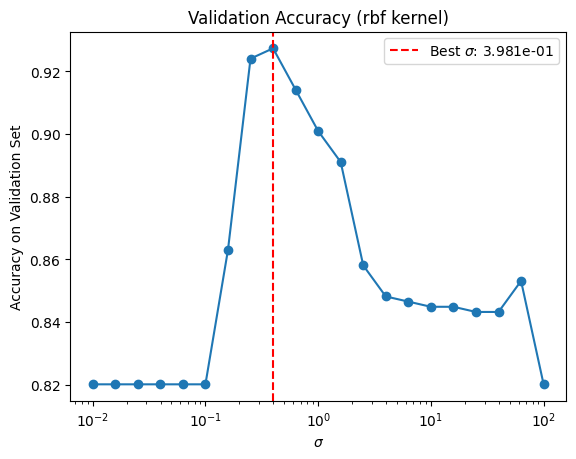

Best sigma: 3.981e-01
Best Validation Accuracy: 92.74%
Best model Test Accuracy: 88.69%


In [7]:
sigma_values = [10**a for a in np.arange(-2, 2.1, 0.2)]

best_accuracy = 0
best_sigma = None
best_model = None
accuracies = []

# Iterate through hyperparameters
for sigma in tqdm(sigma_values):
    # Train SVM model
    alpha_sv, X_sv, y_sv, b = soft_margin_svm_rbf(X_train_binary, y_train_binary, C=1.0, sigma=sigma)
    
    y_val_pred = np.sign(np.dot(rbf_kernel(X_val_binary, X_sv, sigma), alpha_sv * y_sv) + b)

    model_accuracy = accuracy(y_val_pred, y_val_binary)
    accuracies.append(model_accuracy)
    print(f'Validation Accuracy: {model_accuracy * 100:.2f}%')
    
    # Check if this model is the best so far
    if model_accuracy > best_accuracy:
        best_accuracy = model_accuracy
        best_sigma = sigma
        best_model = alpha_sv, X_sv, y_sv, b
        
# Plotting the accuracies
plt.plot(sigma_values, accuracies, marker='o')
plt.xscale('log')
plt.xlabel(r'$\sigma$')
plt.ylabel('Accuracy on Validation Set')
plt.title(f'Validation Accuracy (rbf kernel)')
plt.axvline(x=best_sigma, color='r', linestyle='--', label=rf'Best $\sigma$: {best_sigma:.3e}')
plt.legend()
plt.show()

# Show the best validation result
print(f'Best sigma: {best_sigma:.3e}')
print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')

# Test the best model on the test dataset
alpha_sv, X_sv, y_sv, b = best_model
y_test_pred = np.sign(np.dot(rbf_kernel(X_test_binary, X_sv, best_sigma), alpha_sv * y_sv) + b)
test_accuracy = accuracy(y_test_pred, y_test_binary) 
print(f'Best model Test Accuracy: {test_accuracy * 100:.2f}%')

In [8]:
print('Confusion Matrix:')
print(confusion_matrix(y_test_binary, y_test_pred))

print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_test_pred) * 100:.2f}%')

Confusion Matrix:
[[169  42]
 [ 35 435]]
Balanced Accuracy: 86.32%


# 3. Using sklearn and finding the best $C$ and kernel

In [9]:
# C values to be tested
C_values = [10**a for a in np.arange(-3, 3.1, 0.2)]

def find_best_C(kernel):
    best_accuracy = 0
    best_C = None
    best_model = None
    accuracies = []
    
    # Iterate through hyperparameters
    for C in tqdm(C_values):
        # Train SVM model
        model = SVC(C=C, kernel=kernel)  # You can change the kernel type if needed
        model.fit(X_train_binary, y_train_binary)
    
        # Predict on validation set
        y_val_prediction = model.predict(X_val_binary)
    
        # Calculate accuracy
        accuracy = accuracy_score(y_val_binary, y_val_prediction)
        accuracies.append(accuracy)
    
        # Check if this model is the best so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_C = C
            best_model = model
    
    # Plotting the accuracies
    plt.plot(C_values, accuracies, marker='o')
    plt.xscale('log')
    plt.xlabel('C (Regularization parameter)')
    plt.ylabel('Accuracy on Validation Set')
    plt.title(f'Validation Accuracy ({kernel} kernel)')
    plt.axvline(x=best_C, color='r', linestyle='--', label=f'Best C: {best_C:.3e}')
    plt.legend()
    plt.show()
    
    # Display the best hyperparameter
    print(f'Result for {kernel} kernel')
    print(f'Best C: {best_C}')
    print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
    
    # Test the final best model on the test dataset
    y_test_prediction = best_model.predict(X_test_binary)
    test_accuracy = accuracy_score(y_test_binary, y_test_prediction)
    print(f'Test Accuracy of the Best Model: {test_accuracy * 100:.2f}%')
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test_binary, y_test_pred))
    print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_binary, y_test_pred) * 100:.2f}%')

100%|██████████| 31/31 [00:02<00:00, 10.63it/s]


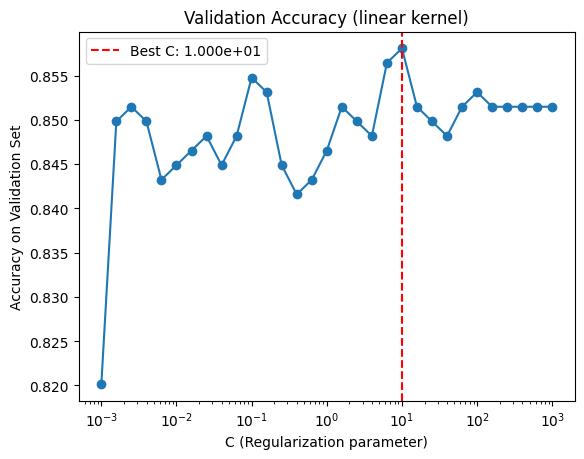

Result for linear kernel
Best C: 10.000000000000082
Best Validation Accuracy: 85.81%
Test Accuracy of the Best Model: 81.20%
Confusion Matrix:
[[169  42]
 [ 35 435]]
Balanced Accuracy: 86.32%


100%|██████████| 31/31 [00:00<00:00, 41.06it/s]


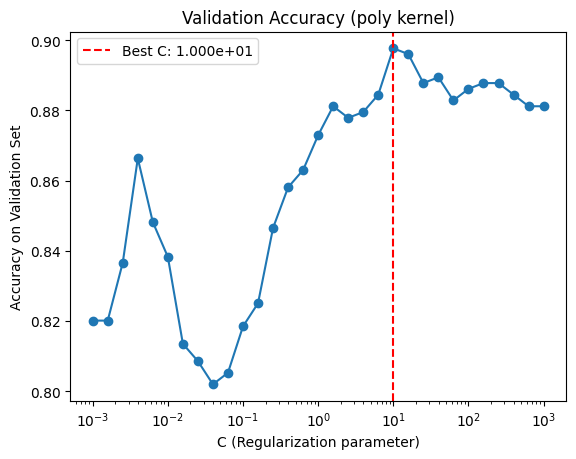

Result for poly kernel
Best C: 10.000000000000082
Best Validation Accuracy: 89.77%
Test Accuracy of the Best Model: 85.02%
Confusion Matrix:
[[169  42]
 [ 35 435]]
Balanced Accuracy: 86.32%


100%|██████████| 31/31 [00:01<00:00, 22.68it/s]


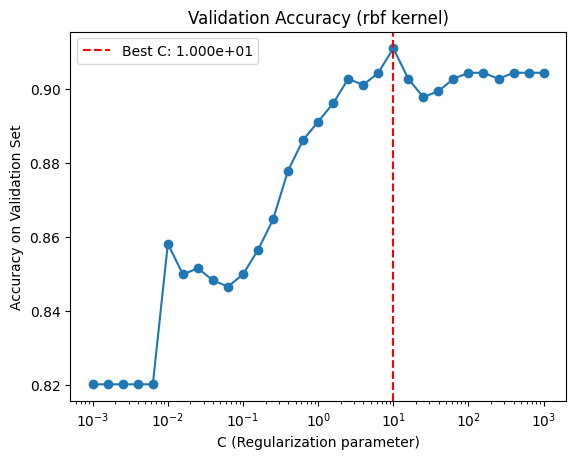

Result for rbf kernel
Best C: 10.000000000000082
Best Validation Accuracy: 91.09%
Test Accuracy of the Best Model: 87.08%
Confusion Matrix:
[[169  42]
 [ 35 435]]
Balanced Accuracy: 86.32%


100%|██████████| 31/31 [00:00<00:00, 40.30it/s]


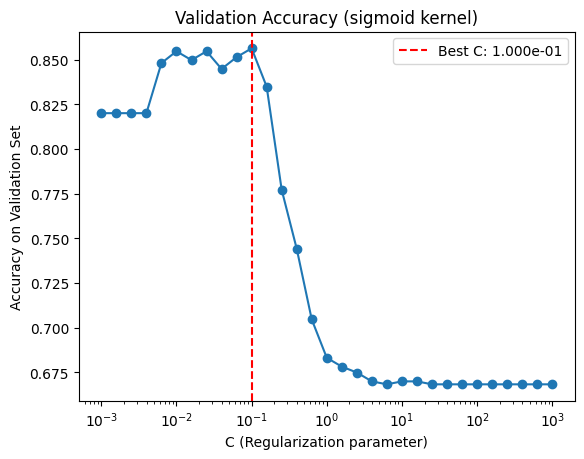

Result for sigmoid kernel
Best C: 0.10000000000000041
Best Validation Accuracy: 85.64%
Test Accuracy of the Best Model: 75.48%
Confusion Matrix:
[[169  42]
 [ 35 435]]
Balanced Accuracy: 86.32%


In [10]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    find_best_C(kernel)

میبینیم که ظاهرا بهترین کرنل 
RBF
و بهترین مقدار 
$C$
برابر با 10 است.

# 4. Multiclass Classification

روشی که اینجا استفاده میکنم ظاهرا به 
One-vs-All (OvA)
یا یکی در برابر بقیه معروف است. یعنی k دسته‌بند آموزش می‌دهیم که هر کدام بین دسته‌ی خودش و بقیه‌ی دسته‌ها انتخاب می‌کند.
نهایتا بین آن‌هایی که مقدار درونی خودشان را انتخاب کرده‌اند آنی را که بیشترین اطمینان از جوابش را دارد انتخاب می‌کنیم.

In [11]:
k = 6

# Best hyperparameters from previous parts
# (I know these are for one-vs-one, but I am going to use them here as well anyway!)
C = 10.0
kernel = 'rbf'
sigma = best_sigma  

# Train k soft-margin SVM models
svm_models = []
for i in tqdm(range(1, k+1)):
    # i -> 1, !i -> -1
    y_train_binary_i = np.where(y_train == i, 1, -1)
    
    gamma = 1 / (2 * sigma**2)
    svm_classifier = SVC(C=100.0, kernel='rbf', gamma=gamma, probability=True)
    
    svm_classifier.fit(X_train, y_train_binary_i)
    svm_models.append(svm_classifier)

# Combine the k models into a single model
def final_model_predict(X):
    # Predict probabilities for each class using individual models
    class_probs = [model.predict_proba(X)[:, 1] for model in svm_models]
    
    # Choose the class with the highest probability
    return np.argmax(class_probs, axis=0) + 1

# Test the final model on the test dataset
y_test_pred = final_model_predict(X_test)

# Report accuracy
print(f'Accuracy on the test dataset: {accuracy_score(y_test, y_test_pred) * 100:.2f}%')
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_test_pred))
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_test_pred) * 100:.2f}%')

100%|██████████| 6/6 [00:11<00:00,  1.89s/it]


Accuracy on the test dataset: 89.55%
Confusion Matrix:
[[452   5   1   0   3   0]
 [  0 221   0   0   1   2]
 [  3   6 366  17   2   3]
 [  0   5  32 132   3  39]
 [  3   9   2   2 213   8]
 [  1   7  16  26  13 407]]
Balanced Accuracy: 87.99%
